In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [17]:
df = pd.read_csv("CC GENERAL.csv")
df.drop(columns="CUST_ID", inplace=True)  # eliminar ID

In [18]:
# Llenar valores faltantes con mediana
for col in ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']:
    df[col].fillna(df[col].median(), inplace=True)

C:\Users\JPabl\AppData\Local\Temp\ipykernel_10876\3448029335.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\JPabl\AppData\Local\Temp\ipykernel_10876\3448029335.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [19]:
# Escalar datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)


In [20]:
pca = PCA()
pca.fit(data_scaled)
explained_var = pca.explained_variance_ratio_.cumsum()


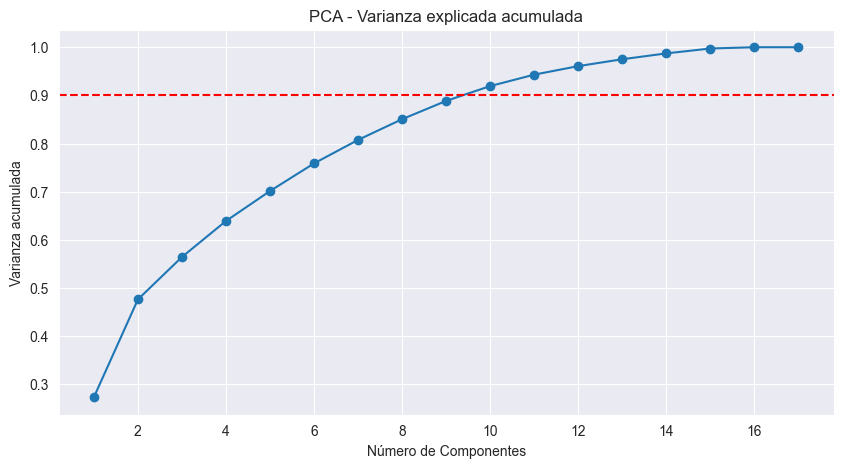

In [21]:
# Graficar varianza acumulada
plt.figure(figsize=(10,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza acumulada")
plt.title("PCA - Varianza explicada acumulada")
plt.show()

In [22]:
# Elegimos componentes que expliquen ~90% de la varianza
n_components = np.argmax(explained_var >= 0.90) + 1
print(f"Número de componentes para 90% de varianza: {n_components}")

Número de componentes para 90% de varianza: 10


In [23]:
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

In [24]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_pca)

In [25]:
# Añadir clusters a los datos originales
df['Cluster'] = clusters

In [26]:
# Estadísticas por cluster (media y desviación)
cluster_summary = df.groupby('Cluster').agg(['mean', 'std'])
print(cluster_summary)

             BALANCE              BALANCE_FREQUENCY              PURCHASES  \
                mean          std              mean       std         mean   
Cluster                                                                      
0        4586.893120  2764.386592          0.968125  0.091309   525.467034   
1         974.643717  1327.140923          0.941907  0.151711  1376.831069   
2        4019.193535  3676.603636          0.984362  0.066363  9422.900224   
3        1008.825091  1110.629647          0.789339  0.294831   276.335344   

                     ONEOFF_PURCHASES              INSTALLMENTS_PURCHASES  \
                 std             mean          std                   mean   
Cluster                                                                     
0         931.157084       335.251337   711.987956             190.300635   
1        1201.870110       688.873179  1002.025943             688.140864   
2        6724.937231      6306.406269  6222.078180            3118.7

In [27]:
# Escalado para ver diferencias relativas
df_scaled = pd.DataFrame(data_scaled, columns=df.columns[:-1])
df_scaled['Cluster'] = clusters
cluster_scaled_summary = df_scaled.groupby('Cluster').mean()
print(cluster_scaled_summary)


          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                             
0        1.452097           0.383528  -0.223606         -0.154950   
1       -0.283380           0.272855   0.174876          0.058101   
2        1.179351           0.452072   3.940854          3.442575   
3       -0.266958          -0.371191  -0.340213         -0.229723   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                     -0.244134      1.705714            -0.497982   
1                      0.306399     -0.361996             1.007790   
2                      2.994252     -0.144658             1.128543   
3                     -0.382115     -0.188478            -0.772581   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
0                 

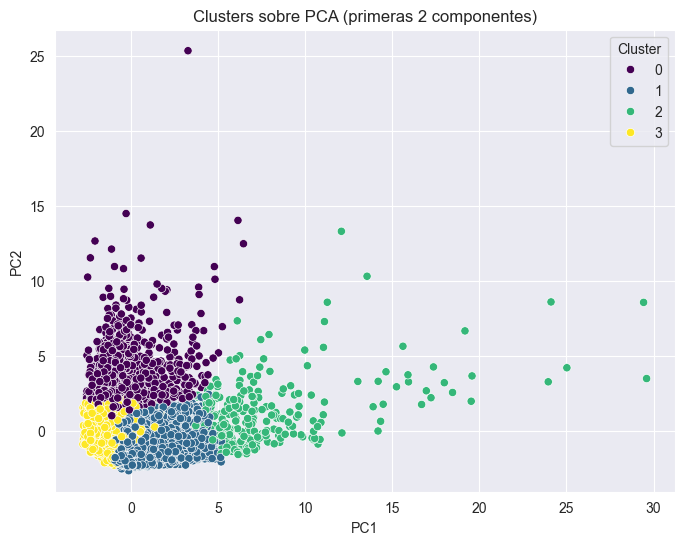

In [28]:
df_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i + 1}' for i in range(n_components)])
df_pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca_df, palette='viridis')
plt.title("Clusters sobre PCA (primeras 2 componentes)")
plt.show()

In [29]:
score = silhouette_score(data_pca, clusters)
print(f"Silhouette Score K-Means: {score:.3f}")

Silhouette Score K-Means: 0.221


In [30]:
# Elegimos variables más representativas, por ejemplo:
variables_interes = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'CREDIT_LIMIT', 'MINIMUM_PAYMENTS']
profile = df.groupby('Cluster')[variables_interes].mean()
print(profile)

             BALANCE  BALANCE_FREQUENCY    PURCHASES  CREDIT_LIMIT  \
Cluster                                                              
0        4586.893120           0.968125   525.467034   7564.623680   
1         974.643717           0.941907  1376.831069   4389.223631   
2        4019.193535           0.984362  9422.900224  10488.432836   
3        1008.825091           0.789339   276.335344   3285.278324   

         MINIMUM_PAYMENTS  
Cluster                    
0             2017.697859  
1              661.883322  
2             2442.668630  
3              548.400848  


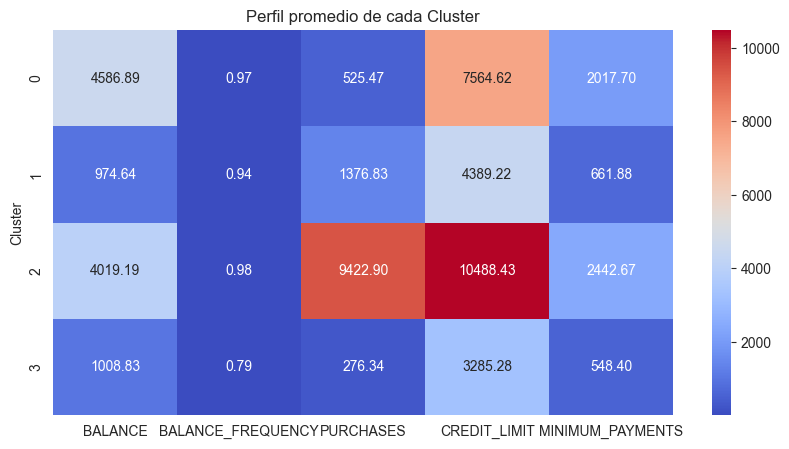

In [31]:
# Puedes graficar un heatmap de los perfiles
plt.figure(figsize=(10,5))
sns.heatmap(profile, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Perfil promedio de cada Cluster")
plt.show()